# Crystal symmetry in ASE

This notebook provides an introduction to some of the crystal symmetry features in ASE and spglib.

It is intended as a self-guided tour, with small problems set in **bold text**. A few example systems are used, and readers are strongly encouraged to try out these tools with systems they are interested in, especially those with non-primitive unit cells and where data is available from geometry optimisation or structure prediction.

> Notes written in quote blocks give tips that are related more to Python, IPython and Jupyter features.
> Some familiarity with Python is assumed, but these tips should be helpful for completing the problems.

The tutorial will first look at how we can apply known symmetry information when creating a system, then move on to analysing the symmetry of an existing structure.

## Bravais lattices
The simplest crystal structures are defined entirely by their periodicity; the position of the atom within the unit cell is unimportant.

Here we consider metallic silver: the list of available Bravais lattices in ASE is available [here](https://wiki.fysik.dtu.dk/ase/ase/lattice.html#available-crystal-lattices).

In [1]:
import ase.lattice

ag_lattice = ase.lattice.FCC(a=4.09) # Face-centered cubic
print("Made a lattice for Ag: ", type(ag_lattice))

assert isinstance(ag_lattice, ase.lattice.BravaisLattice)

Made a lattice for Ag:  <class 'ase.lattice.FCC'>


This is an instance of the FCC class which is derived from a parent class *BravaisLattice*. We don't work with BravaisLattice directly, but it provides features to its "children". Here we have set up an instance of FCC with lattice parameters matching metallic silver. To make an Atoms object, we convert to a unit cell and then to Atoms.
> In Python, we can compare types with `type(x) == type(y)` but this will only succeed if they are exactly the same.
> It is often more robust to use `isinstance()`, which will return True if the object type matches _or inherits from_ the compared type.

In [3]:
from ase import Atoms
ag_cell = ag_lattice.tocell()
ag_atoms = Atoms('Ag', cell=ag_cell, pbc=True)
print(ag_atoms.cell)

Cell([[0.0, 2.045, 2.045], [2.045, 0.0, 2.045], [2.045, 2.045, 0.0]])


Note that _Atoms_ needs to know what element we are using, while the _Cell_ does not. Because there is one atom and it doesn't matter where it goes, we didn't have to specify any positions.

This operation has constructed a *primitive* cell of Ag rather than the cubic cell with 4.09Å sides.
We can view the structure with ASE's inbuilt viewer. By default the `ase.visualize.view` command will create a pop-up window with the structure in it (you may need to move your browser window to spot it!)

In [4]:
from ase.visualize import view
view(ag_atoms)

A more notebook-friendly option is to plot with matplotlib. (Interactive notebook viewers are also avilable; see the [ASE docs](https://wiki.fysik.dtu.dk/ase/ase/visualize/visualize.html#viewer-for-jupyter-notebooks).)

<IPython.core.display.Javascript object>


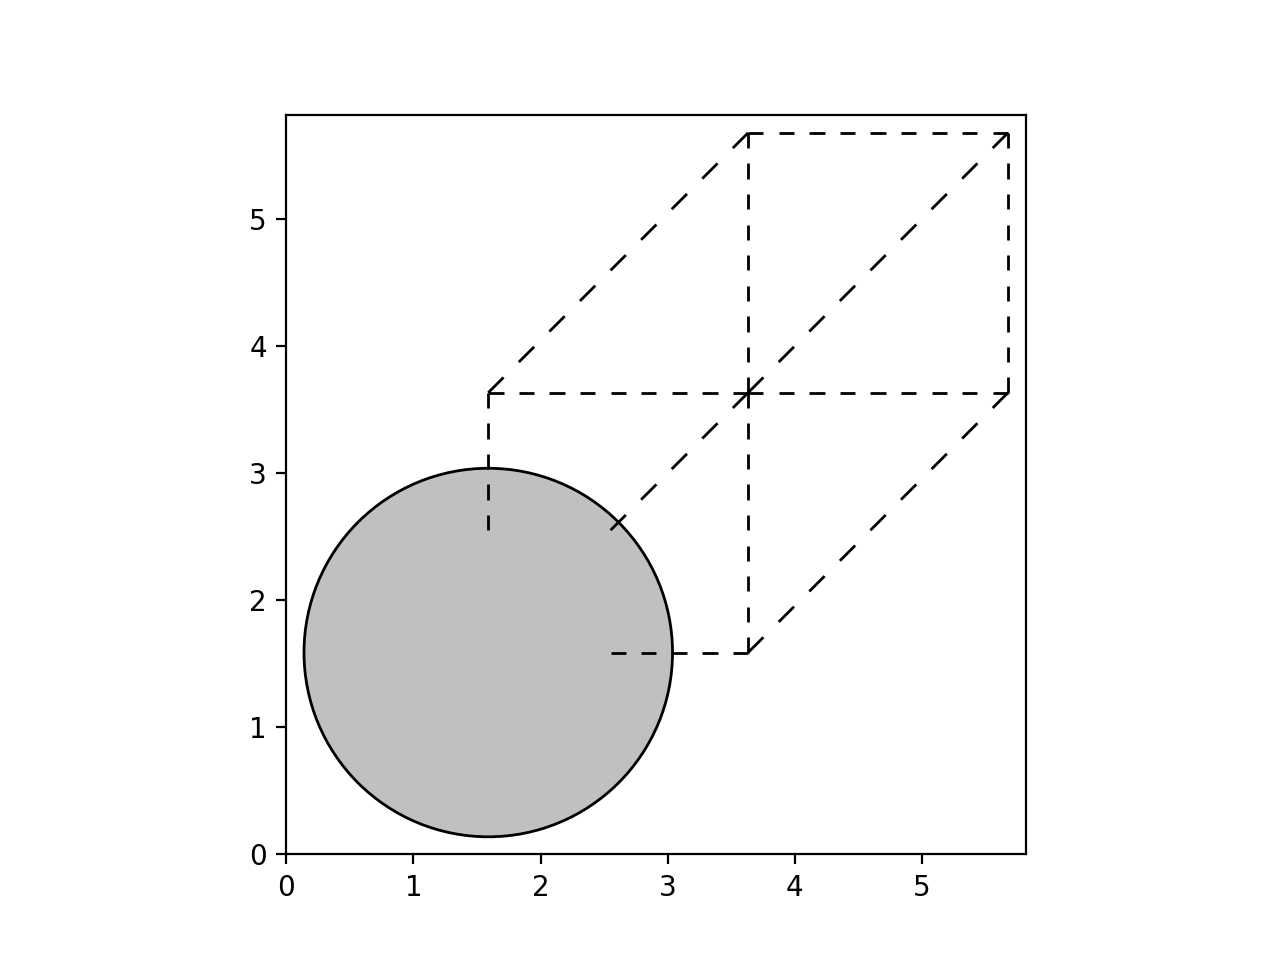

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
plot_atoms(ag_atoms)

**Now try to build a tetragonal unit cell. Visualise it to see if it makes sense.**

> It's not obvious what the lattice generating functions will be named.
> We could look in the documentation or the source code, but from an iPython terminal
> or Jupyter notebook there is another convenient option: tab-completion.
> Type `ase.lattice.` and hit the tab key a few times to open a list of available options.
> These are all the classes, functions and properties available in the `ase.lattice` module.


## Space groups

In crystallography, material structures are typically defined by a combination of
- Bravais lattice
- Symmetry operations
- Atomic basis

All the possible combinations of Bravais lattice types and symmetry operations have been determined by group theory and are assigned to crystallogaphic space groups. There are a few notation schemes, and arguably the easiest to work with are the sequential numbers 1-230 given in the *International Tables for Crystallography, vol. A*.

Let's examine a public-domain .cif file from Crystallography Open Database. Put this file, downloaded from www.crystallography.net/cod/cif/1/52/68/1526860.cif, in the current working directory a rename it to *quartz.cif*.

> From a Linux or Mac system it's possible to make a call to the Bash shell to display the file, even though this is primarily a Python notebook, with the "cell magic" `%%bash`. You can also view this file with a text editor.

In [6]:
%%bash
cat quartz.cif

#------------------------------------------------------------------------------
#$Date: 2016-02-13 21:28:24 +0200 (Sat, 13 Feb 2016) $
#$Revision: 176429 $
#$URL: svn://www.crystallography.net/cod/cif/1/52/68/1526860.cif $
#------------------------------------------------------------------------------
#
# This file is available in the Crystallography Open Database (COD),
# http://www.crystallography.net/
#
# All data on this site have been placed in the public domain by the
# contributors.
#
data_1526860
loop_
_publ_author_name
'Tucker, M.G.'
'Dove, M.T.'
'Keen, D.A.'
_publ_section_title
;
 A detailed structural characterization of quartz on heating through the
 alpha - beta transition
;
_journal_name_full               'Mineralogical Magazine (1969-)'
_journal_page_first              489
_journal_page_last               507
_journal_volume                  65
_journal_year                    2001
_chemical_formula_sum            'O2 Si'
_chemical_name_systematic        'Si O2'
_space_

Working from the bottom to the top of the file, we see in the last two lines that coordinates are only provided for two atoms in the cell. The "loop_" lines above define that format for these coordinates -- CIF is not the most concise format for structure data! Above these lines we see a loop over symmetry operations:
```
loop_
_symmetry_equiv_pos_as_xyz
x,y,z
-y,x-y,z+1/3
-x+y,-x,z+2/3
y,x,-z
-x,-x+y,-z+1/3
x-y,-y,-z+2/3
```

`x,y,z` is the identity operation and `y,x,-z` is a rotation/reflection operation. The other operations include translations in the z axis - given that we only have one Si and one O in the basis, these *must* create some extra atoms.

At the top of the file are lattice parameters and metadata, including several definitions of the spacegroup.
```
_space_group_IT_number           152
_symmetry_space_group_name_Hall  'P 31 2"'
_symmetry_space_group_name_H-M   'P 31 2 1'
```

In the `ase.spacegroup` module we find the command `ase.spacegroup.crystal` which allows us to build an _Atoms_ object using this crystallographic information.

> This may not be the most obvious place as a user to look for this function: other high-symmetry "structure builder" functions live in `ase.build`. However, this is the module that contains the underlying symmetry tools, as we'll see in the next part of the tutorial.

<IPython.core.display.Javascript object>


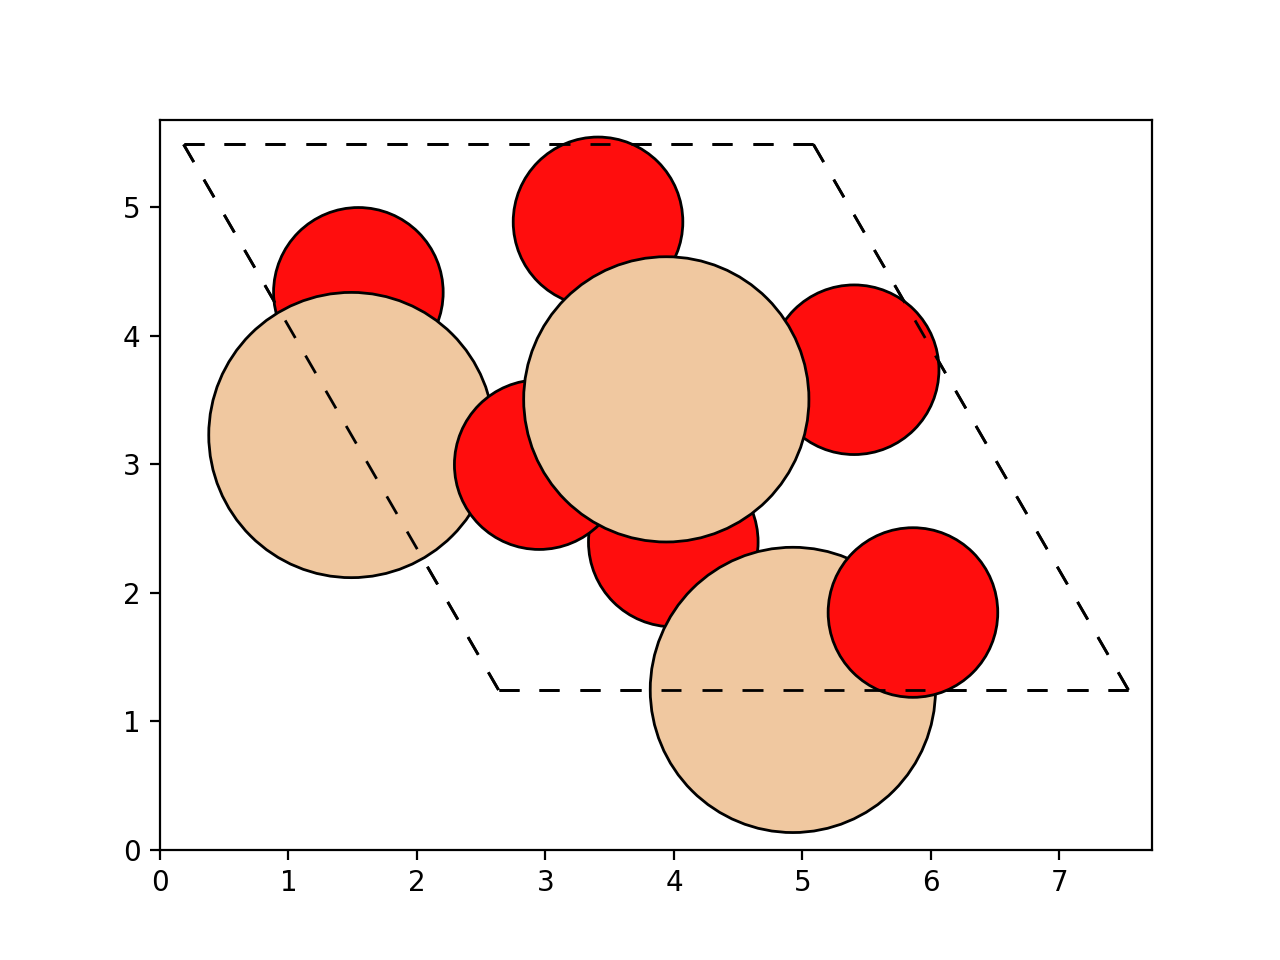

In [7]:
import ase.spacegroup
quartz = ase.spacegroup.crystal(symbols=['O', 'Si'],
                                basis=[[0.413, 0.2711, 0.2172],
                                       [0.4673, 0, 0.3333]],
                                spacegroup=152,
                                cellpar=[4.9019, 4.9019, 5.3988, 90, 90, 120])
fig, ax = plt.subplots()
plot_atoms(quartz)

**Convince yourself that this structure is sensible**

> Hopefully you can find out that this is a network of tetrahedral units, consisting of Si surrounded by O. It may be helpful to open the 3D viewer (using `view()`) and use the "repeats" option in the View menu to expand the viewing region. Alternatively, we can dump out a structure with e.g. `quartz.write('POSCAR', vasp5=True)` for viewing in your favourite atomistic structure viewer (e.g. VESTA).

You can also open up the original .cif file and see if the results agree.

You don't *have* to make structures from .cif files this way. ASE has CIF support built-in, and we could have saved ourselves a lot of trouble with

In [8]:
import ase.io
atoms = ase.io.read('quartz.cif')

but it's not unusual to find structures specified this way in research papers or textbooks.

**Examine a .cif file for a high-symmetry material of interest to your research. How many symmetry operations are there? What happens when you construct the cell in ASE?**

### Getting the symmetry operations
How did ASE do that?

ASE has a data structure for spacegroups that includes information about the symmetry operations, loaded from a data table.

In [9]:
spg = ase.spacegroup.Spacegroup(152)
print("Is a-quartz centrosymmetric? {}".format("yes" if spg.centrosymmetric else "no"))
print("Is the a-quartz lattice primitive? {}".format("yes" if spg.lattice == 'P' else "no"))
print("What symbol is this spacegroup? {}".format(spg.symbol))

Is a-quartz centrosymmetric? no
Is the a-quartz lattice primitive? yes
What symbol is this spacegroup? P 31 2 1


This Class provides access to the actual symmetry operations as a list or iterator.

In [10]:
for i, (rot, trans) in enumerate(spg.get_symop()):
    print("Symmetry operation #{}".format(i + 1))
    print("Rotation matrix: ", rot[0,:])
    print("                 ", rot[1,:])
    print("                 ", rot[2,:])
    print("Translation vector: ", trans)
    print()

Symmetry operation #1
Rotation matrix:  [1 0 0]
                  [0 1 0]
                  [0 0 1]
Translation vector:  [0. 0. 0.]

Symmetry operation #2
Rotation matrix:  [ 0 -1  0]
                  [ 1 -1  0]
                  [0 0 1]
Translation vector:  [0.         0.         0.33333333]

Symmetry operation #3
Rotation matrix:  [-1  1  0]
                  [-1  0  0]
                  [0 0 1]
Translation vector:  [0.         0.         0.66666667]

Symmetry operation #4
Rotation matrix:  [0 1 0]
                  [1 0 0]
                  [ 0  0 -1]
Translation vector:  [0. 0. 0.]

Symmetry operation #5
Rotation matrix:  [ 1 -1  0]
                  [ 0 -1  0]
                  [ 0  0 -1]
Translation vector:  [0.         0.         0.66666667]

Symmetry operation #6
Rotation matrix:  [-1  0  0]
                  [-1  1  0]
                  [ 0  0 -1]
Translation vector:  [0.         0.         0.33333333]



Hopefully these operations look familiar from the CIF file!

**Have a look at the symmetry operations from some other spacegroups. Can you identify rotation, reflection and glide operations?**

To generate a structure with these operations, ASE uses the symops in a method `Spacegroup.equivalent_sites`. This takes positions in fractional coordinates and applies the symmetry operations to derive a set of images. If we provide just the Si atom from the .cif file, we get our original site back, with two other images - this is consistent with the cell of three formula units.

In [37]:
spg.equivalent_sites([0.4673, 0, 0.3333])

(array([[0.4673    , 0.        , 0.3333    ],
        [0.        , 0.4673    , 0.66663333],
        [0.5327    , 0.5327    , 0.99996667]]), [0, 0, 0])

**What does the [0, 0, 0] mean? This is not part of the equivalent_sites array. Have a look at the docstring...**
>
> To examine detailed help from a regular python terminal you could use `help(ase.spacegroup.Spacegroup)`.
> To inspect the manually-written docstring part directly you could print `ase.spacegroup.Spacegroup.__doc__`.
> From an iPython terminal or Jupyter notebook the most convenient option is the special syntax `ase.spacegroup.Spacegroup?`.
> Most functions in ASE should have docstrings, so adding a `?` to a half-written line of code can be very helpful in the heat of the moment.

**What happens if you include redundant sites in the input to *equivalent_sites()*?**

## Analysing symmetry in existing structures

Many atomistic codes are "smart" about how they use symmetry. They can identify symmetry and use this to:

- reduce the amount of information to be calculated;
- reduce the size of data files;
- impose constraints on calculated structures and fields.

However, there are several reasons reasearchers _should_ be aware (and possibly worried) about the symmetry of their system, including:

- working with primitive/conventional unit cells as appropriate;
- identifying unique sites for substitutions and defects;
- identifying when symmetry was broken by numerical errors;
- avoiding the imposition of excessive symmetry on top of the _magnetic_ spacegroup.

### Identifying the spacegroup

Going back to the quartz cell that was imported from a .cif file, we can have a look at some metadata stored in the `info` attribute of *Atoms*.

In [13]:
atoms.info

{'spacegroup': Spacegroup(152, setting=1),
 'unit_cell': 'conventional',
 'occupancy': {0: {'O': 1}, 1: {'Si': 1}}}

The spacegroup was actually set as a tag when it was imported. Let's break the symmetry slightly by making some random changes to the atom positions.

In [14]:
atoms.rattle()
atoms.positions

array([[ 1.36052887e+00,  1.15072730e+00,  1.17326705e+00],
       [ 3.22672813e+00,  6.02155459e-01,  2.97198522e+00],
       [ 2.76919195e+00,  2.49268218e+00,  4.77134989e+00],
       [ 3.17205300e-01,  1.75279176e+00,  4.22571491e+00],
       [ 7.74497067e-01,  3.64086703e+00,  6.25255722e-01],
       [-1.09148013e+00,  3.09329153e+00,  2.42689489e+00],
       [ 2.28974985e+00, -1.41230370e-03,  1.80088569e+00],
       [-1.14555471e+00,  1.98383544e+00,  3.59759529e+00],
       [ 1.30507668e+00,  2.26151294e+00,  5.39746905e+00]])

This didn't change the tag, so to get the correct symmetry we need to analyse the structure.

In [15]:
ase.spacegroup.get_spacegroup(atoms)

Spacegroup(1, setting=1)

We now have spacegroup 1, with zero symmetry. That's an accurate assessment of the system, but there are plenty of cases where we have a structure that isn't quite _perfect_ and we'd like to know what high-symmetry structure is nearby. To do this we can increase the tolerance used to determine if atoms are "in the same position".

In [16]:
ase.spacegroup.get_spacegroup(atoms, symprec=1e-2)

Spacegroup(152, setting=1)

This useful function is actually provided by [spglib](https://atztogo.github.io/spglib), an external library written in C. The performance benefits of C are quite helpful here, as determining the spacegroup involves applying many symmetry operations and analysing the results. Spglib includes a Python API and the integration into ASE is not too complicated. We can also access the same function directly

In [17]:
from spglib import get_spacegroup
get_spacegroup((atoms.cell, atoms.get_scaled_positions(), atoms.numbers),
               symprec=1e-2)

'P3_121 (152)'

It's a bit more cumbersome compared to calling directly from ASE because spglib doesn't know how to read an Atoms object, so we extract the necessary parts and put them in a `(tuple)`.
**When might it be useful to call this function directly? Look at the docstring...**

### Cleaning up a structure with standardize_cell

There are a few more functions in the *spglib interface* that are not directly provided in ASE.

Suppose your collaborator has asked you to calculate some properties and has sent you the structure file *mystery.cell* (included in the directory with this notebook).

In [18]:
mystery_atoms = ase.io.read('mystery.cell')
ase.spacegroup.get_spacegroup(mystery_atoms)

Spacegroup(1, setting=1)

Well, you _could_ assume the structure is already perfect and we are simply dealing with a low-symmetry system.

**Visualise the structure. Does this look low-symmetry to you?**

It's not always easy to judge by eye. We don't know what spacegroup the material is _supposed_ to have. A useful procedure in this scenario is to look at how sensitive the spacegroup is to the distance threshold.

In [21]:
for symprec in (1e-5, 5e-4, 1e-4, 1e-3, 5e-3, 1e-2, 1e-1):
    print("Threshold: {}  Spacegroup: {}".format(symprec,
                                                 ase.spacegroup.get_spacegroup(mystery_atoms,
                                                                               symprec=symprec).symbol))

Threshold: 1e-05  Spacegroup: P 1
Threshold: 0.0005  Spacegroup: P 1
Threshold: 0.0001  Spacegroup: P 1
Threshold: 0.001  Spacegroup: P 1
Threshold: 0.005  Spacegroup: I -4
Threshold: 0.01  Spacegroup: I -4
Threshold: 0.1  Spacegroup: I -4


So there is an I-4 system within a small atomic movement. It's possible that the symmetry-breaking is real, of course, but it would be nice to do some calculations with the high-symmetry system and get those efficiency improvements.

In [24]:
from spglib import standardize_cell

`standardize_cell` replaces the older `find_primitive` and `refine_cell` functions, and is generally recommended for this purpose.

In [27]:
mystery_cell = (mystery_atoms.cell, mystery_atoms.get_scaled_positions(), mystery_atoms.numbers)
new_cell = standardize_cell(mystery_cell, to_primitive=False, symprec=5e-3)
new_cell

(array([[ 5.38326953,  0.        ,  0.        ],
        [ 0.        ,  5.38326953,  0.        ],
        [ 0.        ,  0.        , 10.72708263]]),
 array([[0.        , 0.5       , 0.75      ],
        [0.        , 0.        , 0.5       ],
        [0.25965518, 0.76835118, 0.38004812],
        [0.23164882, 0.25965518, 0.61995188],
        [0.76835118, 0.74034482, 0.61995188],
        [0.74034482, 0.23164882, 0.38004812],
        [0.5       , 0.        , 0.75      ],
        [0.5       , 0.5       , 0.5       ],
        [0.5       , 0.        , 0.25      ],
        [0.5       , 0.5       , 0.        ],
        [0.75965518, 0.26835118, 0.88004812],
        [0.73164882, 0.75965518, 0.11995188],
        [0.26835118, 0.24034482, 0.11995188],
        [0.24034482, 0.73164882, 0.88004812],
        [0.        , 0.5       , 0.25      ],
        [0.        , 0.        , 0.        ]]),
 array([29, 29, 16, 16, 16, 16, 50, 30, 29, 29, 16, 16, 16, 16, 50, 30],
       dtype=int32))

Note that an spglib _cell_ is more analogous to _Atoms_ in ASE than to a _Cell_ in ASE. To convert this to an Atoms object we can feed the data into an Atoms constructor. This is made especially clear using Python's variable-unpacking syntax `x, y, z = a`.

<IPython.core.display.Javascript object>


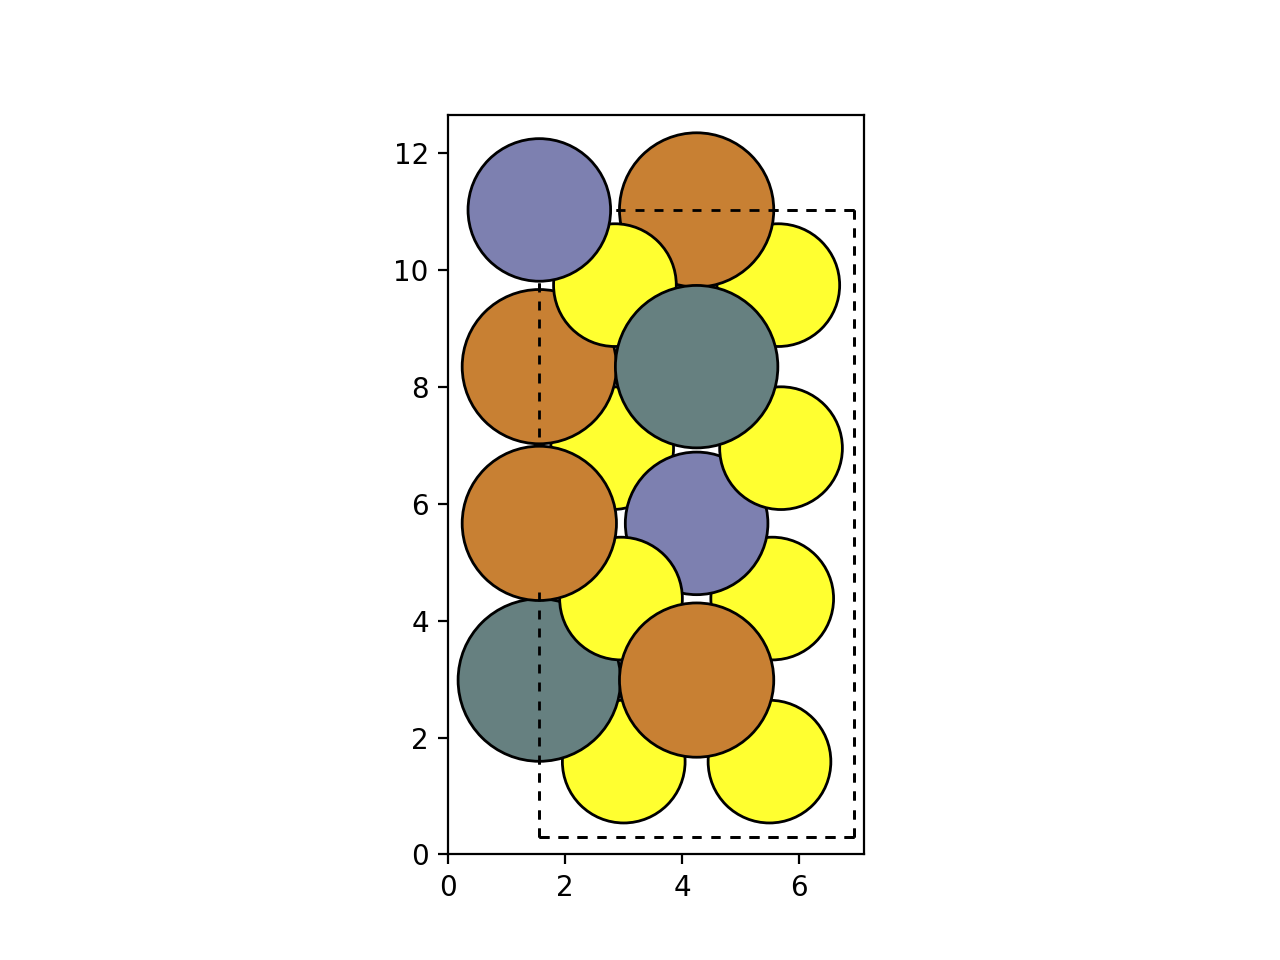

In [35]:
new_unit_cell, new_scaled_positions, new_numbers = new_cell
new_atoms = Atoms(new_numbers, cell=new_unit_cell, scaled_positions=new_scaled_positions)
fig, ax = plt.subplots()
plot_atoms(new_atoms, rotation='90x,90y')

**Write this structure to a .cell file and compare it with the input mystery.cell file**

This cell contains more atoms than the original data file. For many purposes this _conventional_ unit cell is preferred, but generally it will be more efficient to perform further calculations using the smaller _primitive_ cell.

**Generate a primitive cell instead and write this to your preferred geometry file format.**
> `spglib.standardize_cell` contains what you need to do this.

**Final exercise:**
The "mystery" system is a photovoltaic absorber material which has been found to consistently under-perform compared to its theoretical efficiency limit. This might be due to its defect chemistry. The formation energies of isolated vacancies can be computed by constructing a supercell and removing appropriate atoms. How many inequivalent atom sites do we need to consider in this material?

> Have a look at the available methods to Spacegroup and see which ones might be useful. There are several options!

(This kind of study has been performed a few times, and recent work with hybrid DFT suggests that sulfur vacancies do play a significant role in this system.)